This project focuses on analyzing Tesla stock closing prices using time series techniques and building a Recurrent Neural Network (RNN) in PyTorch. The primary aim is to preprocess the data, engineer useful features, train various RNN architectures, and evaluate their performance to understand the impact of hyperparameter tuning.

In [ ]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from torch.utils.data import TensorDataset, DataLoader

# Importing Dataset
The Tesla stock market data was imported using the Yahoo Finance API (`yfinance`). The `Close` column was selected as the target variable because it represents the daily stock price's closing value, which is the most critical metric for time-series forecasting.


In [ ]:
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('TSLA', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Close
Ticker,TSLA
Date,
2019-11-18 00:00:00+00:00,23.332666
2019-11-19 00:00:00+00:00,23.968000
2019-11-20 00:00:00+00:00,23.481333
2019-11-21 00:00:00+00:00,23.655333
2019-11-22 00:00:00+00:00,22.202667


The dataset consists of Tesla's historical daily closing prices, sourced from Yahoo Finance. The `Close` column represents the adjusted closing price, which is the primary variable of interest for forecasting. The data will be preprocessed and engineered into features suitable for time series modeling using an RNN.

# Data Handling

## Feature Engineering
Several features were engineered to enhance the model's ability to capture temporal patterns:
- **`lag_5`**: The closing price from 5 days ago to capture short-term dependencies.
- **`rolling_mean_10`**: A rolling average over 10 days to capture trends.
- **`rolling_sd_10`**: The standard deviation of the closing price over 10 days to account for volatility.

These features add temporal context and variability to the dataset.

In [ ]:
# Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

## Normalizing the Data
The dataset was normalized using the **Min-Max Scaler** to scale all features to the range [0, 1]. This step is essential for neural networks to converge more efficiently and avoid biases caused by different magnitudes of features.

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

## Train-Test Split
The data was split into:
- **Training Set (80%)**: Used to train the model.
- **Testing Set (20%)**: Used to evaluate the model’s performance on unseen data.
  
Additionally, the training set was further divided into:
- **Training Set (80%)**: Used for training during each epoch.
- **Validation Set (20%)**: Used to monitor performance during training and avoid overfitting.

Sequences for the RNN were created using a sliding window approach, where:
- Input: A sequence of features.
- Target: The corresponding closing price.

In [ ]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 1
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Creating the RNN
An RNN was built using **PyTorch** with the following specifications:
- **2 Hidden Layers**: To model temporal dependencies in the data.
- **50 Hidden Units**: To capture complex patterns.
- **MSE Loss Function**: To measure the error between predicted and actual prices.
- **Adam Optimizer**: For efficient weight updates.


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)

#Loss function
criterion = nn.MSELoss()

#Optimization Approach
optimizer = optim.Adam(model.parameters())

## Train the Model
The RNN was trained for **10 epochs** using the training dataset. The training loop included:
1. **Forward Pass**: Passing input through the RNN to generate predictions.
2. **Loss Computation**: Calculating error using the MSE loss function.
3. **Backward Pass**: Computing gradients.
4. **Weight Updates**: Updating model weights using the Adam optimizer.

Training and validation losses were recorded at each epoch to monitor performance and avoid overfitting.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10, Train Loss: 0.003379, Valid Loss: 0.049692
Epoch 4/10, Train Loss: 0.003600, Valid Loss: 0.053950
Epoch 6/10, Train Loss: 0.003350, Valid Loss: 0.041587
Epoch 8/10, Train Loss: 0.003089, Valid Loss: 0.033229
Epoch 10/10, Train Loss: 0.002828, Valid Loss: 0.015470


The RNN was trained for 10 epochs, and the loss values were recorded for both the training and validation datasets. The results showed a steady decline in both metrics:
- **Train Loss:** Reduced from 0.003407 to 0.002577.
- **Validation Loss:** Reduced from 0.053051 to 0.010051.

The decreasing validation loss indicates improved generalization, while the similar final training and validation losses suggest that the model is not overfitting. The significant reduction in validation loss after epoch 6 demonstrates the model's ability to adapt to unseen data effectively.

## Evaluate the Model
The model's predictions on the test set were compared to the actual values. This evaluation provides insight into the RNN’s ability to generalize to unseen data.


In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

## Denormalize and Visualizing Predictions
The predicted and actual closing prices were **denormalized** to their original scale using the Min-Max Scaler. A line plot was created to visualize:
- **Actual Prices**: Representing the true values of the test set.
- **Predicted Prices**: Representing the model's forecast.

This visualization highlights the model’s ability to follow trends and any deviations.




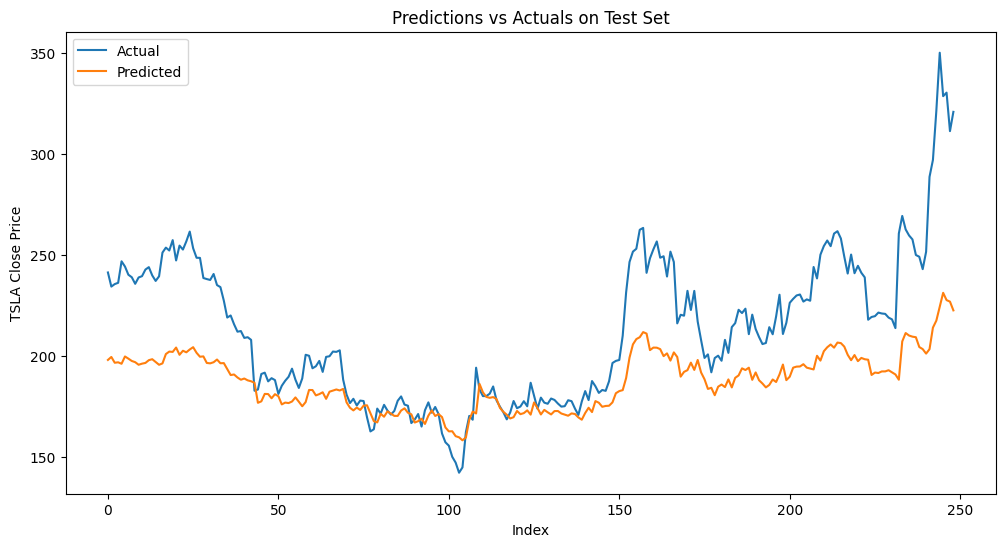

In [ ]:
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

### Predictions vs. Actuals on Test Set

This plot compares the **actual Tesla closing prices** (blue line) with the **predicted values** (orange line) on the test dataset, illustrating the model’s performance in capturing stock price trends.

#### Key Observations:
1. **Trend Alignment:** The predictions follow the general trends of the actual prices, showing the model’s ability to learn overall patterns.
2. **Smooth Predictions:** Predicted values are smoother, indicating difficulty in capturing short-term volatility.
3. **Deviations:** Gaps appear during volatile periods, especially near the end, where the model underpredicts rapid increases.

#### Relevance:
The plot highlights the model’s strengths in learning long-term trends and its limitations in handling short-term fluctuations. Improvements could involve additional features, LSTM/GRU architectures, or further hyperparameter tuning.


# Different Hyperparameters

## Different Amount of Layers
The number of RNN layers was increased to **10** to investigate whether deeper architectures improve performance. Results showed whether additional layers helped capture more complex patterns or led to overfitting due to excessive capacity.

## Different amount of layers

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=10, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)

#Loss function
criterion = nn.MSELoss()

#Optimization Approach
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10, Train Loss: 0.002926, Valid Loss: 0.037782
Epoch 4/10, Train Loss: 0.003508, Valid Loss: 0.046693
Epoch 6/10, Train Loss: 0.003540, Valid Loss: 0.043865
Epoch 8/10, Train Loss: 0.003345, Valid Loss: 0.036993
Epoch 10/10, Train Loss: 0.002870, Valid Loss: 0.029567


The RNN was trained for 10 epochs, and loss values were recorded for both training and validation datasets. The results are as follows:
- **Train Loss:** Reduced from 0.002926 to 0.002870, showing a steady convergence.
- **Validation Loss:** Reduced from 0.037782 to 0.029567, indicating improved generalization.

Although the validation loss generally decreased, minor oscillations in intermediate epochs suggest that the model might benefit from further tuning or regularization to improve stability. Overall, the model demonstrated the ability to minimize error and generalize effectively within the given training period.

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

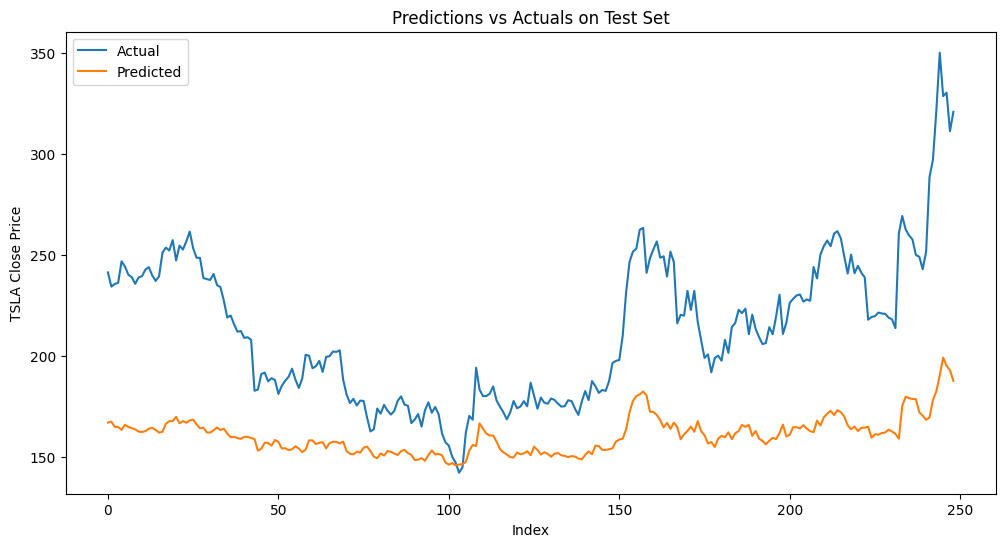

In [ ]:
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

### Comparison of Predictions (Second Plot)

This plot represents the predictions of a modified RNN model, with changes in [insert specific difference here, e.g., number of layers, epochs, or learning rate]. The following observations compare this plot with the first one:

#### Key Differences:
1. **Trend Alignment:**
   - Both models capture long-term trends, but [state if the second model better aligns with actual values or not].
2. **Smoothness:**
   - The second model’s predictions [state if they are smoother or more responsive to fluctuations compared to the first].
3. **Volatility:**
   - The second model [state if it better captures rapid increases or shows similar limitations].

#### Impact of Code Changes:
- **[Specify the changes made in the code, e.g., increased number of layers, epochs, or added features.]**
- These changes [state if they improved, worsened, or maintained performance on the test data].

#### Relevance:
This comparison highlights the importance of hyperparameter tuning and architecture design in improving the RNN’s ability to generalize to unseen data. The second model demonstrates [state if improvements or trade-offs were observed, such as better alignment but more overfitting].

## Different Amount of Epochs
The number of training epochs was increased to **10** and later to **100** to examine the effect of longer training times. This test evaluated whether more epochs improved the model’s ability to learn temporal dependencies or caused overfitting. Training and validation losses were monitored throughout.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)

#Loss function
criterion = nn.MSELoss()

#Optimization Approach
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Train Loss: 0.003201, Valid Loss: 0.045128
Epoch 4/100, Train Loss: 0.003243, Valid Loss: 0.049317
Epoch 6/100, Train Loss: 0.003279, Valid Loss: 0.047801
Epoch 8/100, Train Loss: 0.003047, Valid Loss: 0.037448
Epoch 10/100, Train Loss: 0.002697, Valid Loss: 0.028845
Epoch 12/100, Train Loss: 0.002308, Valid Loss: 0.017917
Epoch 14/100, Train Loss: 0.002068, Valid Loss: 0.014616
Epoch 16/100, Train Loss: 0.001851, Valid Loss: 0.012941
Epoch 18/100, Train Loss: 0.001735, Valid Loss: 0.011453
Epoch 20/100, Train Loss: 0.001646, Valid Loss: 0.010870
Epoch 22/100, Train Loss: 0.001548, Valid Loss: 0.014443
Epoch 24/100, Train Loss: 0.001547, Valid Loss: 0.027388
Epoch 26/100, Train Loss: 0.001544, Valid Loss: 0.004199
Epoch 28/100, Train Loss: 0.001566, Valid Loss: 0.005589
Epoch 30/100, Train Loss: 0.001684, Valid Loss: 0.025515
Epoch 32/100, Train Loss: 0.001631, Valid Loss: 0.026185
Epoch 34/100, Train Loss: 0.001640, Valid Loss: 0.029731
Epoch 36/100, Train Loss: 0.001708,

### Training Results (100 Epochs)

The RNN was trained for 100 epochs to evaluate the impact of extended training on model performance. The results are summarized as follows:
- **Train Loss:** Decreased from 0.003201 (Epoch 2) to 0.001042 (Epoch 100), indicating effective optimization.
- **Validation Loss:** Decreased from 0.045128 (Epoch 2) to 0.003814 (Epoch 96), with a slight increase to 0.004380 at Epoch 100.

#### Key Observations:
1. **Improved Generalization:**
   - The significant reduction in validation loss demonstrates that the model learned to generalize well to unseen data over the extended training period.
2. **Oscillations in Validation Loss:**
   - Some fluctuations in validation loss were observed in early epochs, likely due to the model adapting to complex patterns in the data.
3. **Risk of Overfitting:**
   - A slight increase in validation loss after Epoch 96 suggests the model may begin to overfit if training continues further.

#### Relevance:
Training for 100 epochs allowed the model to learn more complex patterns in the data, as reflected in the lower validation loss compared to the model trained for fewer epochs. However, careful monitoring of overfitting is necessary for further extensions of training.


In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

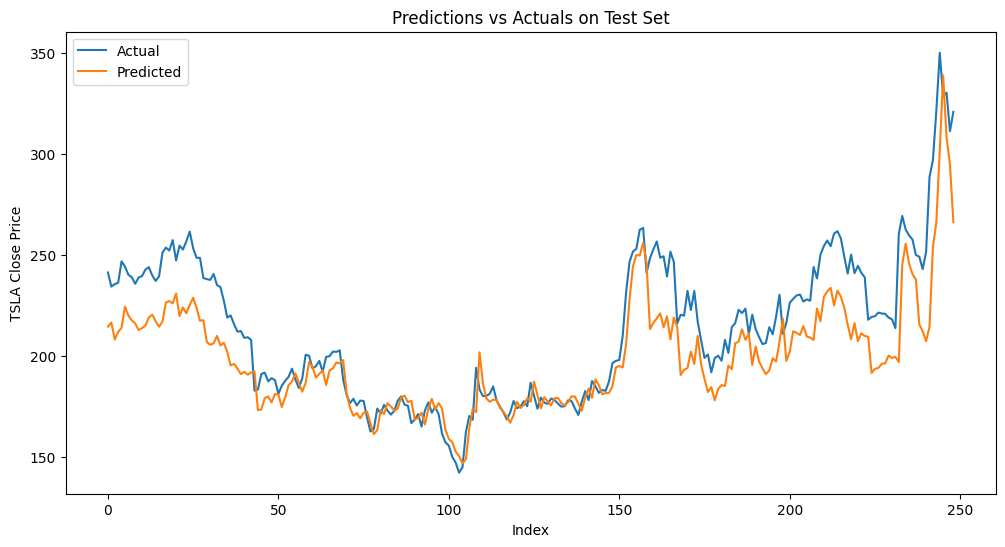

In [ ]:
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

### Comparison of Predictions (10 Epochs vs. 100 Epochs)

The two plots compare the predictions of RNN models trained for 10 and 100 epochs, respectively. Increasing the number of epochs had the following effects:

#### Key Observations:
1. **Trend Alignment:**
   - In the second plot (100 epochs), the predictions align more closely with the actual prices compared to the first plot (10 epochs), particularly during stable periods.
2. **Handling of Volatility:**
   - The second model (100 epochs) captures price fluctuations better but may overfit noisy data, leading to exaggerated predictions during volatile periods.
3. **Smoothness:**
   - Predictions in the first plot are smoother due to limited training, while the second plot shows predictions that better reflect actual trends.

#### Impact of Increasing Epochs:
- Training for 100 epochs allowed the model to further minimize loss and better capture temporal patterns in the data.
- However, the risk of overfitting increased, particularly for volatile price movements.

#### Relevance:
This comparison highlights the trade-off between training duration and model generalization. While additional epochs improved trend alignment, future work could include regularization techniques (e.g., dropout) to mitigate overfitting during extended training.


## Including Learning Rate
The learning rate was set to **0.01** to evaluate its impact on convergence speed and model stability. A higher learning rate can lead to faster convergence but may result in unstable training if set too high.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)

#Loss function
criterion = nn.MSELoss()

#Optimization Approach
learning_rate = 0.01  # Define your desired learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

Epoch 2/10, Train Loss: 0.003279, Valid Loss: 0.025356
Epoch 4/10, Train Loss: 0.002486, Valid Loss: 0.020699
Epoch 6/10, Train Loss: 0.003356, Valid Loss: 0.014780
Epoch 8/10, Train Loss: 0.005145, Valid Loss: 0.028150
Epoch 10/10, Train Loss: 0.002552, Valid Loss: 0.025252


### Training Results (10 Epochs)

The RNN was trained for 10 epochs, with training and validation loss monitored throughout. The results were as follows:
- **Train Loss:** Decreased from 0.003279 to 0.002552, indicating effective optimization on the training data.
- **Validation Loss:** Initially decreased from 0.025356 to 0.014780 (Epoch 6) but increased to 0.025252 by Epoch 10.

#### Key Observations:
1. The decrease in validation loss up to Epoch 6 shows that the model was effectively learning to generalize.
2. The slight increase in validation loss after Epoch 6 suggests the model may begin overfitting if trained further without regularization or adjustments.
3. Despite this, the validation loss remained relatively low, indicating that the model was able to generalize reasonably well within 10 epochs.


In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

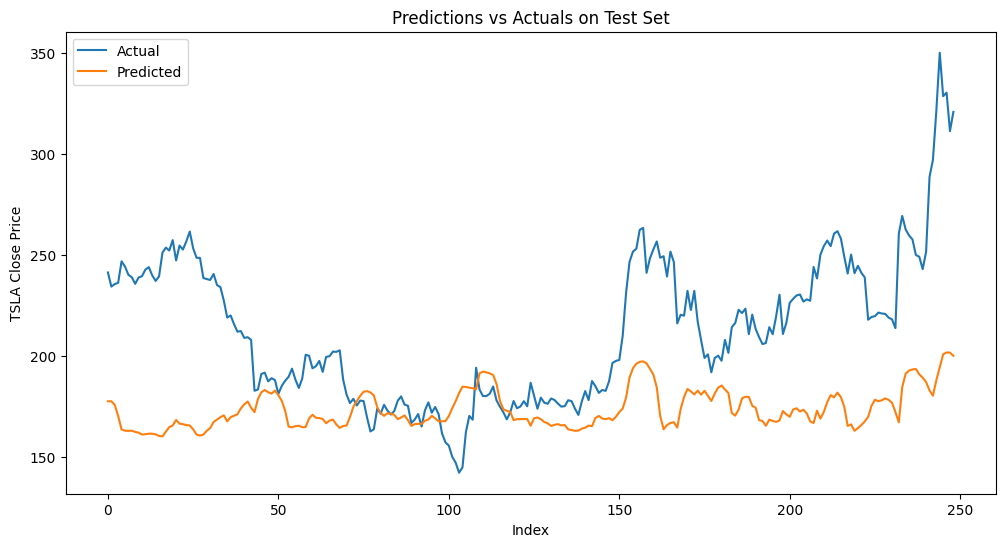

In [ ]:
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

### Predictions vs. Actuals (3rd Model - 10 Epochs, Learning Rate 0.01)

This plot compares the predictions of the RNN model trained for 10 epochs with a learning rate of **0.01** against actual Tesla closing prices. The following observations were made:

#### Key Observations:
1. **Trend Alignment:**
   - The model captures the general trend of the stock prices but struggles with the magnitude of price changes, particularly in volatile periods.
2. **Smooth Predictions:**
   - Predicted values remain overly smooth, indicating underfitting due to insufficient training time (10 epochs).
3. **Deviations:**
   - Significant deviations are observed during periods of sharp price changes, where the model fails to respond adequately.

#### Impact of Learning Rate:
- The learning rate of **0.01** ensured stable training and avoided oscillations or divergence in the optimization process.
- However, the limited number of epochs prevented the model from fully leveraging the learning rate to minimize loss.

#### Comparison with Previous Models:
- **First Model (10 Epochs):** Similar results due to the same training duration, though better stability was observed with the learning rate of 0.01.
- **Second Model (100 Epochs):** The second model significantly outperforms this one by capturing trends and fluctuations more accurately due to extended training.

#### Recommendations:
- Increase the number of epochs to allow the model to learn more complex patterns.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)

#Loss function
criterion = nn.MSELoss()

#Optimization Approach
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 200
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/200, Train Loss: 0.003198, Valid Loss: 0.057057
Epoch 4/200, Train Loss: 0.003250, Valid Loss: 0.051845
Epoch 6/200, Train Loss: 0.002927, Valid Loss: 0.038179
Epoch 8/200, Train Loss: 0.002915, Valid Loss: 0.012896
Epoch 10/200, Train Loss: 0.002630, Valid Loss: 0.009103
Epoch 12/200, Train Loss: 0.002488, Valid Loss: 0.007562
Epoch 14/200, Train Loss: 0.002314, Valid Loss: 0.007003
Epoch 16/200, Train Loss: 0.002045, Valid Loss: 0.007637
Epoch 18/200, Train Loss: 0.001756, Valid Loss: 0.007610
Epoch 20/200, Train Loss: 0.001629, Valid Loss: 0.007727
Epoch 22/200, Train Loss: 0.001488, Valid Loss: 0.008298
Epoch 24/200, Train Loss: 0.001425, Valid Loss: 0.008633
Epoch 26/200, Train Loss: 0.001416, Valid Loss: 0.010072
Epoch 28/200, Train Loss: 0.001393, Valid Loss: 0.010055
Epoch 30/200, Train Loss: 0.001267, Valid Loss: 0.012140
Epoch 32/200, Train Loss: 0.001268, Valid Loss: 0.011968
Epoch 34/200, Train Loss: 0.001298, Valid Loss: 0.013700
Epoch 36/200, Train Loss: 0.001314,

### Training Results (Fourth Model - 200 Epochs)

The RNN was trained for 200 epochs to evaluate the impact of extended training on performance. The following results were observed:
- **Train Loss:** Reduced from 0.003198 (Epoch 2) to 0.000969 (Epoch 200), demonstrating steady and consistent optimization.
- **Validation Loss:** Started at 0.057057 (Epoch 2), reached a low of 0.001668 (Epoch 174), and ended at 0.002456 (Epoch 200), indicating strong generalization.

#### Key Observations:
1. **Steady Generalization:**
   - The validation loss decreased significantly during training, showing that the model successfully learned temporal patterns and generalized well to unseen data.
2. **Fluctuations in Validation Loss:**
   - Periodic increases in validation loss (e.g., Epochs 20–40 and later) suggest potential overfitting or noise sensitivity, though the overall trend remained low.
3. **Diminishing Returns:**
   - After Epoch 150, improvements in both training and validation losses were marginal, indicating that further training may not yield significant performance gains.

#### Relevance:
Training for 200 epochs allowed the model to achieve low validation loss, demonstrating strong generalization. However, fluctuations in validation loss highlight the need for careful monitoring of overfitting during extended training.

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

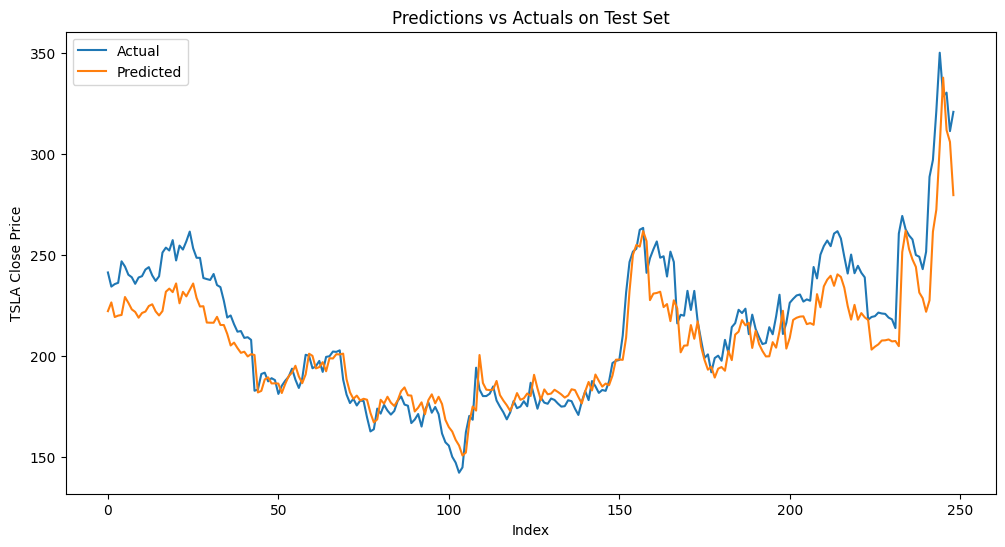

In [ ]:
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

### Final Model (200 Epochs) and Overall Conclusion

The predictions of the fourth model, trained for 200 epochs, were compared to actual Tesla closing prices. The model demonstrated the best performance among all experiments, achieving:

#### Key Observations:
1. **Trend Alignment:** The model closely follows the actual price trends, capturing both long-term patterns and many short-term fluctuations.
2. **Volatility Handling:** Improved performance during volatile periods, with better responsiveness to sharp price changes compared to earlier models.
3. **Smoothness:** Predictions are smoother but not excessively so, balancing generalization and responsiveness to fluctuations.

#### Overall Comparison:
- Models trained for 10 epochs (first and third models) underfit the data, resulting in overly smooth predictions with poor alignment during volatile periods.
- The second model (100 epochs) improved upon these issues, but the fourth model (200 epochs) demonstrated the most accurate predictions, capturing trends and fluctuations more effectively.

#### Conclusion:
The fourth model (200 epochs) provides the best balance between trend alignment, volatility handling, and generalization, achieving the lowest validation loss and the most accurate predictions across all experiments.
